機械学習のコンペで高精度のモデル、あるいは機械学習にしかできない高速・高精度の性能を活かした面白いアプリの制作を目指す。

データサイエンティストは主にコンサルタイプ・エンジニアタイプのデータアナリスト、機械学習エンジニア、ディープラーニングエンジニア、研究者の5つに分かれる。自分は特にエンジニアタイプのデータアナリスト、様々なモデルを扱える機械学習エンジニアを目指す予定。

「必要な技術は必要な時に学べばよい」
→分析コンペで課題に触れる。

Kaggleの1000チーム以上参加のメダル取得条件
- 金、上位10チーム+0.2%
- 銀、上位5%
- 銅、上位10%

Kaggleの分析コンペで学べるのは、とくにモデルの実用精度を検証する概念実証(PoC)の段階。
分析設計、データの前処理、特徴量生成、モデリングがカバー範囲。

Kaggleを学習に生かすには、以下のプロセスで学習をする。
- 学習目的の設定
- コンペの選択
- 分析環境の準備
- コンペの推進
- 技術の調査
- 振り返り

まずは「評価指標の算出と可視化をする」「ベースラインの段階で寄与率を算出する」などこれまでの分析手法を振り返る、
「LightGBMで精度を挙げる方法を検証する」など分析環境と手法を学ぶ機会を設け、学習目標を明確にする。
また学習目的を決めたらそれに合ったものを選択するのも重要。今回は「実践力」で学んだことに加え
これまでに学習した機械学習の基礎を振り返る記事を書く予定。

## 今回の学習目的
「評価指標の算出と可視化をする」「ベースラインの段階で寄与率を算出する」などの基礎を振り返りながら機械学習の基礎を学習する。

- ベースライン作成
- 特徴量の作成
- モデルのチューニング

# ベースライン作成
目的変数、精度の検証、評価指標を決めてまずは最低限の性能を持つ機械学習モデルを構築する。
書籍のベースライン作成の他、LazyPredictを使って20の機械学習の評価指標を算出する方法を記事にする予定。

ベースライン作成が終わったら実験と仮説検証の繰り返してベースラインのコードに肉付けをしていく。

今回はタイタニック予測のベースライン作成を行う。
タイタニック予測のは分類問題なので、評価指標はPrecision、Recall、Accuracy、AUC（適合率、再現率、正解率、予測値の順序性）の4つとなる。

# インポート

In [19]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認に使う
# import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理、特徴量作成 - sklearnを使う
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# モデリング・精度と評価指標
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#LGBM
import lightgbm as lgb

#どうでもいい警告は無視する設定に
import warnings
warnings.filterwarnings("ignore")

In [20]:
# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [39]:
df_train = pd.read_csv("titanic_datasets/train.csv")
df_train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [36]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
df_train.value_counts()

PassengerId  Survived  Pclass  Name                                                  Sex     Age   SibSp  Parch  Ticket    Fare      Cabin  Embarked
2            1         1       Cumings, Mrs. John Bradley (Florence Briggs Thayer)   female  38.0  1      0      PC 17599  71.2833   C85    C           1
572          1         1       Appleton, Mrs. Edward Dale (Charlotte Lamson)         female  53.0  2      0      11769     51.4792   C101   S           1
578          1         1       Silvey, Mrs. William Baird (Alice Munger)             female  39.0  1      0      13507     55.9000   E44    S           1
582          1         1       Thayer, Mrs. John Borland (Marian Longstreth Morris)  female  39.0  1      1      17421     110.8833  C68    C           1
584          0         1       Ross, Mr. John Hugo                                   male    36.0  0      0      13049     40.1250   A10    C           1
                                                                                 

## データ確認
データ数、カラム数、データ型を確認する

In [22]:
print("データ形状：")
print(df_train.shape)

print("データ数：")
print(len(df_train))

print("データのコラム数")
print(len(df_train.columns))

データ形状：
(891, 12)
データ数：
891
データのコラム数
12


In [23]:
print("データ型一覧")
df_train.info()

データ型一覧
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# ベースライン作成
まず量的データのみを使ったベースラインモデルを作成する

In [24]:
X_train, y_train, id_train = df_train[["Pclass","Age","SibSp","Parch","Fare"]], df_train[["Survived"]], df_train[["PassengerId"]]
X_train.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [25]:
y_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [26]:
# データ形状が問題ないか判定
print(X_train.shape)
print(y_train.shape)
print(id_train.shape)

(891, 5)
(891, 1)
(891, 1)


## ホールドアウト検証
学習用・テスト用の分割を1通り決める

In [27]:
# ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

学習用・訓練用データの形状：
(712, 5)
(712, 1)
(179, 5)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


## 交差検証
学習用・テスト用の分割をテスト用の割合の逆数分だけ繰り返す。偏ったデータによる過学習を防止できる利点があるが、その分学習に時間がかかる。

In [28]:
"""
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))

for nfold in np.arrange(n_splits):
    # 分割分だけデータセットを作成する
    print("-"*20, nfold, "-"*20)
    
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(X_tr.shape, y_tr.shape)
    print(X_va.shape, y_va.shape)
    
    # データのラベルに偏りがないか表示
    y_train_mean = y_train["Survived"].mean()
    y_tr_mean = y_tr["Survived"].mean()
    y_va_mean = y_va["Survived"].mean()
    
    print("全体の生存者割合：")
    print(y_train_mean)
    print("学習用フォールドの生存者割合：")
    print(y_tr_mean)
    print("検証用フォールドの生存者割合：")
    print(y_va_mean)
    
    #機械学習はこの段階で開始
"""

'\nn_splits = 5\ncv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))\n\nfor nfold in np.arrange(n_splits):\n    # 分割分だけデータセットを作成する\n    print("-"*20, nfold, "-"*20)\n    \n    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]\n    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]\n    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]\n    print(X_tr.shape, y_tr.shape)\n    print(X_va.shape, y_va.shape)\n    \n    # データのラベルに偏りがないか表示\n    y_train_mean = y_train["Survived"].mean()\n    y_tr_mean = y_tr["Survived"].mean()\n    y_va_mean = y_va["Survived"].mean()\n    \n    print("全体の生存者割合：")\n    print(y_train_mean)\n    print("学習用フォールドの生存者割合：")\n    print(y_tr_mean)\n    print("検証用フォールドの生存者割合：")\n    print(y_va_mean)\n    \n    #機械学習はこの段階で開始\n'

# モデル学習
LightGBMでベースラインモデルを作成。テーブルデータを使った教師あり学習では大抵コレを使う。
- モデルの精度がそれなりに高い
- 処理が高速
- カテゴリ変数を自動で前処理してくれる
- 欠損値を自動で前処理してくれる
- 異常値の影響を受けにくい

In [29]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

(712, 5)
(712, 1)
(179, 5)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


In [30]:
# LGBMのパラメータ
params = {"boosting_type":"gbdt",
          "objective":"binary",
          "metric":"auc",
          "learning_rate":0.1,
          "num_leaves":16,
          "n_estimators":1000,
          "random_state":123,
          "importance_type":"gain",
          "early_stopping_round":100,
          "verbose":10
          }

# LGBMのモデル
model = lgb.LGBMClassifier(**params)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.725421
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.293539
[LightGBM] [Debug] init for col-wise cost 0.000282 seconds, init for row-wise cost 0.000124 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug

LGBMClassifier(early_stopping_round=100, importance_type='gain', metric='auc',
               n_estimators=1000, num_leaves=16, objective='binary',
               random_state=123, verbose=10)

次にモデルを実際に動かして学習精度・検証精度を出します。検証精度は一応ランダムな予測以上の値が出ていますが、AUC率よりも低くまだまだ改善の余地があります。

In [32]:
# AUC値に加え精度を算出する
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("モデル精度:")
print("学習精度")
print(metric_tr)
print("検証精度")
print(metric_va)

モデル精度:
学習精度
0.9058988764044944
検証精度
0.664804469273743


In [33]:
y_tr_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,

In [34]:
y_va_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0], dtype=int64)

In [35]:
y_va

,Survived
561,0
641,1
400,1
498,0
875,1
...,...
339,0
841,0
442,0
815,0


In [ ]:
# モデル学習 - LazyPredict
次に、LazyPredictでベースラインモデルを作成します。

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, random_state=1121, verbose=False,predictions=True)
models, predictions = reg.fit(X_tr, X_va, y_tr, y_va) 

print("モデルの精度・評価指標：")
display(models)
print("テストデータの予測値：")
display(predictions)

100%|██████████| 29/29 [00:01<00:00, 15.41it/s]

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.73,0.72,0.72,0.73,0.02
SVC,0.74,0.71,0.71,0.74,0.08
PassiveAggressiveClassifier,0.71,0.69,0.69,0.71,0.03
QuadraticDiscriminantAnalysis,0.72,0.68,0.68,0.71,0.03
BernoulliNB,0.70,0.67,0.67,0.69,0.07
LinearDiscriminantAnalysis,0.71,0.67,0.67,0.70,0.07
RidgeClassifierCV,0.71,0.67,0.67,0.70,0.02
RidgeClassifier,0.71,0.67,0.67,0.70,0.05
GaussianNB,0.70,0.67,0.67,0.70,0.03


テストデータの予測値：


,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,1,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0,...,1,0,1,1,1,1,1,1,0,1
4,0,1,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0,0,1,1,0,0,1,0,1,0,...,1,0,1,0,1,1,0,0,1,0
175,1,0,0,1,1,0,1,1,0,0,...,0,1,0,1,1,1,0,0,1,1
176,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
177,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,1,0,0,0,0


# 混合行列

In [ ]:
y_pred=model.predict(X_va)
y_pred[:5]

array([0, 1, 0, 0, 0], dtype=int64)

混合行列：
[[78 28]
 [32 41]]


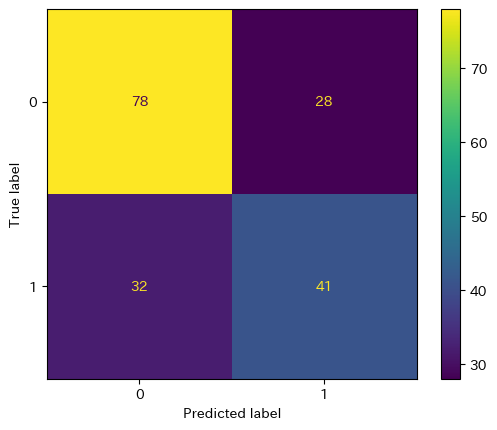

In [ ]:
# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
disp.plot()
plt.show()

In [ ]:
# 生存できなかった人を正しく予測する率の方が生存できなかった人を正しく予測する確率よりも高い。(適合率＞再現率)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

"""
誤検出を少なくしたい場合には適合率
取りこぼしを少なくしたい場合には再現率

「陽性患者の取りこぼしが多いと命に関わるような重大な問題に繋がる」
といったような場合には、再現率を評価指標に使用するのが適切。
"""

#適合率 - TP+TN / (TP+FP+TN+FN) - 単純な正答率
print("正答率")
print(accuracy_score(y_pred, y_va))

#適合率 - TP / (TP+FP) - 予測されたラベルに対する実際に正解となるサンプル
print("適合率")
print(precision_score(y_pred, y_va))

#再現率 - TP / (TP+FN) - 本来正しく予測した場合に対し実際に正解となるサンプル
print("再現率")
print(recall_score(y_pred, y_va))

print("F値")
print(f1_score(y_pred, y_va))

正答率
0.664804469273743
適合率
0.5942028985507246
再現率
0.5616438356164384
F値
0.5774647887323944


In [ ]:
# データ可視化
特徴量エンジニアリングに必要な仮説を立てるには、データを可視化するのも有効。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("titanic_datasets/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


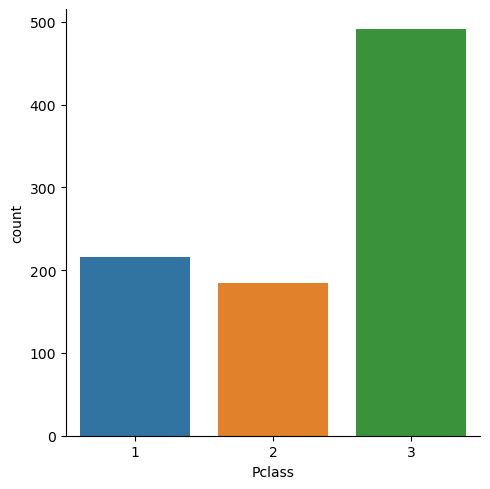

In [ ]:
# 棒グラフ
sns.catplot(x="Pclass", data=df_train, kind="count")

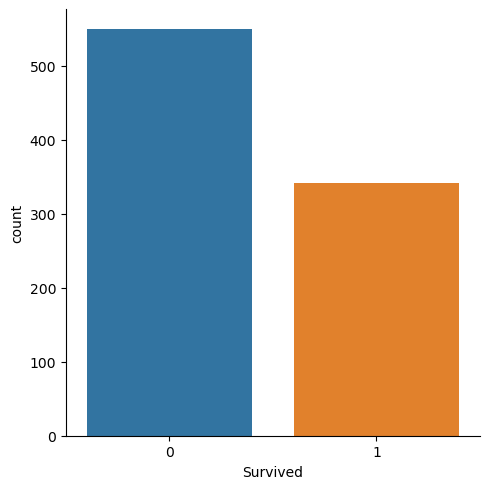

In [ ]:
# 棒グラフ
sns.catplot(x="Survived", data=df_train, kind="count")

In [ ]:
全乗客の内3等客室の人々が半分ほど。1等・2等客室が残りの25%。

C:\Users\user\AppData\Local\Temp\ipykernel_12464\54400219.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['Age'])


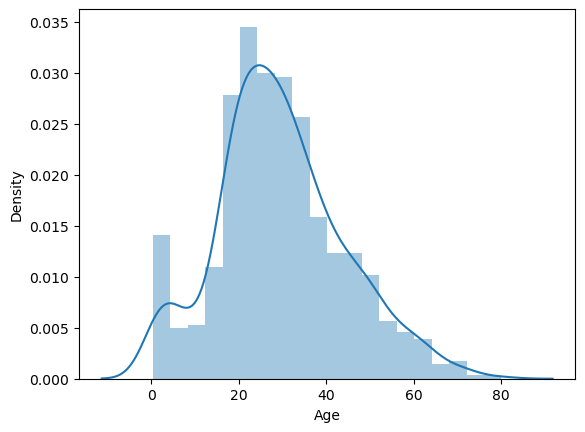

In [ ]:
# ヒストグラム - 年齢の分布
sns.distplot(df_train['Age'])
plt.show()

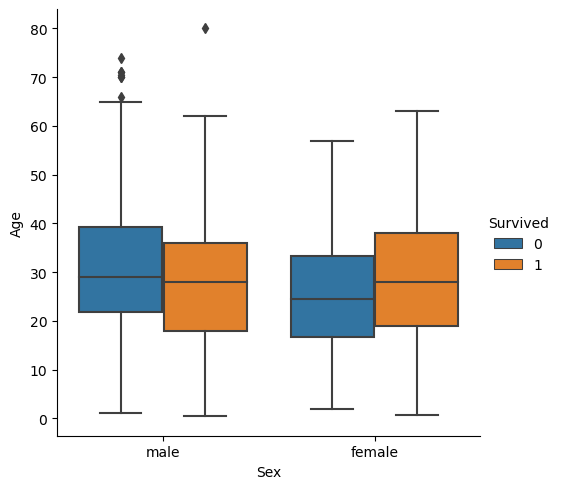

In [ ]:
# 箱ひげ図 - 性別・生存者ごとの年齢の分布
sns.catplot(x='Sex', y='Age', data=df_train, kind='box', hue='Survived')
plt.show()

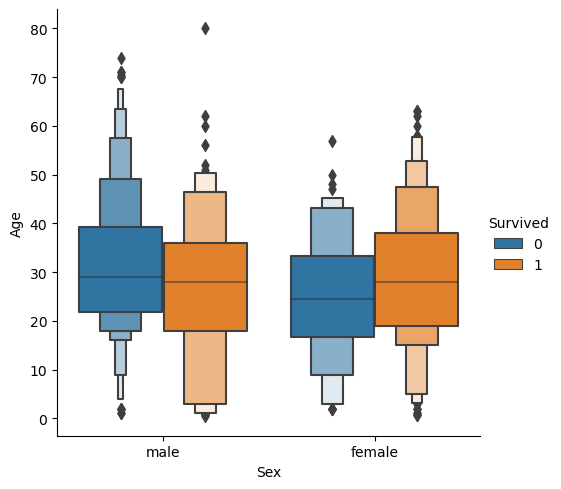

In [ ]:
# 箱ひげ図 - 性別・生存者ごとの年齢の分布
sns.catplot(x='Sex', y='Age', data=df_train, kind='boxen', hue='Survived')
plt.show()

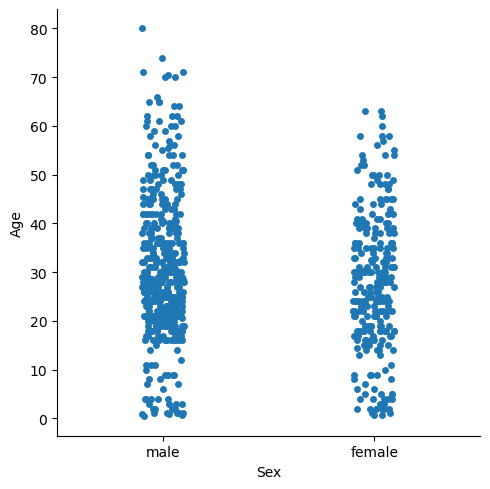

In [ ]:
# 質的変数ごとの散布図
sns.catplot(x='Sex', y='Age', data=df_train)
plt.show()